<a href="https://colab.research.google.com/github/malcolmlett/robovac/blob/main/Experiment_SLAM_data_generation_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment: SLAM Data Generation (v1)
This is the first notebook to really seriously look into generating realistic training data for the SLAM model.

This notebook follows on from `Experiment-SLAM-2.ipynb`.

**Problems identified in Experiment-SLAM-2:**

A number of problems with the data generation were identified there:
* Input maps are too complete and too perfect. They're exactly the same as the ground-truth maps, so there's nothing for the NN to do, and no incentive to use the LDS data to improve the map.
* The NN should always prefer the LDS data over its the input map, as the input map represents only a guess, while LDS is true state. I don't think I've got this balanced quite right in the training data yet.

**Suggestions from Experiment-SLAM-2:**

Some initial ideas for improving the training data were:
* Simulate an agent actually moving around an environment and building up the map from parts, instead of the current extremes: being given either a fully-known map or no-map in between.
  * Imagine taking a path along the map.
  * At each location collect what it can see within the LDS range - this collects a circle of data.
  * Then add some noise the LDS data before turning it into the input map.
  * Later on optionally add motion-skew (where the agent continuously slowly slides slightly to one side so that the SLAM map ends up over a curve and the NN will have to correct that).
  * API note: add collection of options for turning different kinds of errors on/off.
* Play around with occlusions more. Instead of being given a full map for the current location it should be given only a partial map, forcing it to do a partial-match on the map and the LDS data. eg:
  * Randomly drop half of the input map, centred on the map centre, according to a dividing line that goes through the centre at some random angle.
  * Use ~1/3rd sized circles of LDS range and randomly splat them around the map filling in only the parts that are splatted. Do this to build up the input map that is then snapshotted. Take a random number of splats, to simulate different levels of known map. Could be easy to implement by first building up mask from the splats and then applying that against the full map.

In [120]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/robovac.git repo

# lock to revision
#!cd repo && git checkout e33eb2b
!cd repo && git pull

import sys
sys.path.append('repo')

from general_utils import display_history
import lds
import slam
import slam_data
from importlib import reload
reload(lds)
reload(slam)
reload(slam_data)

HEAD is now at 5492782 Bug fixes and minor factoring
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (3/3), 2.10 KiB | 1.05 MiB/s, done.
From https://github.com/malcolmlett/robovac
   5492782..4b14300  main       -> origin/main
Updating 5492782..4b14300
Fast-forward
 slam_data.py | 168 +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++--------------
 1 file changed, 140 insertions(+), 28 deletions(-)


<module 'slam_data' from '/content/repo/slam_data.py'>

In [18]:
!pip install -Uqq ipdb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import io
import os
import shutil
import tarfile
import cv2
import requests
import math
import ipdb
import tqdm
import time
from timeit import default_timer as timer

In [16]:
a = np.array([[0, 50, 0.5], [50, 100, 0.75], [20, None, 0.8]])
r = np.array([2, 20, 40, 50, 60, 70, 80, 90, 100, 120, 150, np.nan])
for start, end, stddev in a:
  print(f"{start} - {end} @ {stddev}")
  mask = (r >= start) & (end is None or r < end)
  noise = np.random.normal(0.0, 1.0, size=r.shape) * r
  #ranges[mask] += noise[mask]
  print(r[mask])
  print(noise[mask])



0 - 50 @ 0.5
[ 2. 20. 40.]
[ -1.8710649  -20.21901749 -51.19588093]
50 - 100 @ 0.75
[50. 60. 70. 80. 90.]
[ 68.85227002 -87.41940067  17.64226826  75.85756191  -2.9997317 ]
20 - None @ 0.8
[ 20.  40.  50.  60.  70.  80.  90. 100. 120. 150.]
[ -16.89898497  -16.10938698   58.06678374   23.37399216    4.90089885
  -70.94329675 -143.42504753  151.00208519  100.35479529  147.45664277]


## LDS sampling with noise

In [21]:
floorplan = Image.open('repo/data/experimental-floorplan2.png')
floorplan = np.array(floorplan, dtype=np.uint8)
print(f"RGB encoded:     shape={floorplan.shape}, dtype={floorplan.dtype}, value range: {np.min(floorplan)} - {np.max(floorplan)}")

floorplan = slam_data.one_hot_encode_floorplan(floorplan).numpy()
print(f"one-hot encoded: shape={floorplan.shape}, dtype={floorplan.dtype}, value range: {np.min(floorplan)} - {np.max(floorplan)}")


RGB encoded:     shape=(139, 294, 3), dtype=uint8, value range: 0 - 255
one-hot encoded: shape=(139, 294, 3), dtype=float32, value range: 0.0 - 1.0


Adding noise with stddev 7.653061224489796
Adding noise with stddev 0.025510204081632654*range = 8.257748173522081 - 88.76344752784487


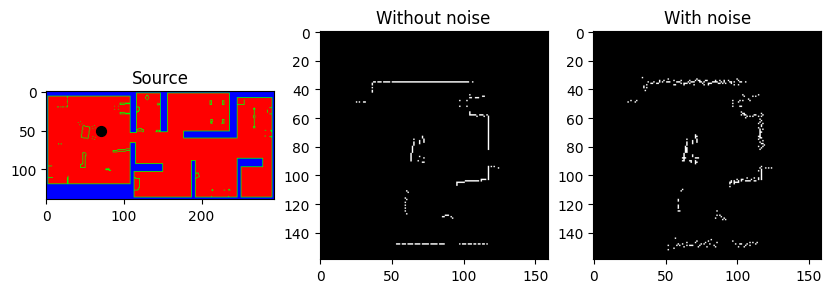

In [60]:
reload(lds)
loc = (70.0, 50.0)
ranges1 = lds.lds_sample(floorplan[:,:,1], np.array(loc) * lds.__PIXEL_SIZE__, angle=0.0, noise_ranges=None)
lds_points1 = lds.lds_to_occupancy_map(ranges1, angle=0.0)

ranges2 = lds.lds_sample(floorplan[:,:,1], np.array(loc) * lds.__PIXEL_SIZE__, angle=0.0)
lds_points2 = lds.lds_to_occupancy_map(ranges2, angle=0.0)

plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.title('Source')
plt.imshow(floorplan)
plt.scatter(loc[0], loc[1], c='k', s=50)

plt.subplot(1,3,2)
plt.title("Without noise")
plt.imshow(lds_points1, cmap='gray')

plt.subplot(1,3,3)
plt.title("With noise")
plt.imshow(lds_points2, cmap='gray')

plt.show()



In [123]:
reload(lds)
reload(slam_data)
#np.random.seed(0)
dataset = slam_data.generate_training_data(floorplan, 5, sample_types=(3))
slam_data.validate_dataset(dataset)
slam_data.show_dataset(dataset)

Generating 5 samples of training data
Pixel size: 44.71
Max distance: 3500
Sample types: [3]


  0%|          | 0/5 [00:00<?, ?it/s]


IndexError: index 139 is out of bounds for axis 0 with size 139

In [117]:
np.linalg.norm(np.array([1,2]), np.array([3,4]))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [100]:
np.ravel(np.array(np.array([5,6])))

array([5, 6])

## Next Steps
Next step is to start using the model to generate the input map in the training data set.

Probably split out the training into aeons.
During the first aeon it'll use ground-truth generated input maps.
At the end of each aeon it'll generate new input maps for the dataset and use them in the next aeon.